In [1]:
import evaluate
import numpy as np
from datasets import load_dataset

accuracy = evaluate.load("accuracy")

In [2]:
dataset_name = 'marsyas/gtzan'
dataset = load_dataset(dataset_name)['train']
dataset = dataset.train_test_split(test_size=0.2, seed=42)
dataset = dataset['test']

Found cached dataset gtzan (/root/.cache/huggingface/datasets/marsyas___gtzan/default/0.0.0/8bd0e23c2d9b2be30d36bc6834319772dff22a3bd28527996612386cef003910)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at /root/.cache/huggingface/datasets/marsyas___gtzan/default/0.0.0/8bd0e23c2d9b2be30d36bc6834319772dff22a3bd28527996612386cef003910/cache-6e258a91c217e67e.arrow and /root/.cache/huggingface/datasets/marsyas___gtzan/default/0.0.0/8bd0e23c2d9b2be30d36bc6834319772dff22a3bd28527996612386cef003910/cache-e6ab41d7131de016.arrow


In [3]:
model_name = 'adamkatav/wav2vec2_100k_gtzan_30s_model'
from transformers import AutoFeatureExtractor
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, sampling_rate=feature_extractor.sampling_rate, max_length=16000*30, truncation=True)
    return inputs


In [4]:
# encoded_minds = dataset.map(preprocess_function, remove_columns="audio", batched=True)
encoded_minds = dataset.map(preprocess_function, remove_columns="audio", batched=True)


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [5]:
label_col = 'genre'
encoded_minds = encoded_minds.rename_column(label_col, "label")

In [6]:
# import evaluate
# import numpy as np

# accuracy = evaluate.load("accuracy")

# def compute_metrics(eval_pred):
#     predictions = np.argmax(eval_pred.predictions, axis=1)
#     return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

In [7]:
import evaluate
import numpy as np

cfm_metric = evaluate.load("BucketHeadP65/confusion_matrix")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return cfm_metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [8]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer
model = AutoModelForAudioClassification.from_pretrained(model_name)

In [9]:
# from datasets import concatenate_datasets
# test_set = concatenate_datasets([encoded_minds['train'], encoded_minds['test']])

In [11]:
training_args = TrainingArguments(
    output_dir="wav2vec2_100k_gtzan_30s_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=1,
    num_train_epochs=1000,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    save_total_limit=2,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=feature_extractor,
    eval_dataset=encoded_minds,
    compute_metrics=compute_metrics,
)

In [12]:
result = trainer.evaluate(eval_dataset=encoded_minds)

Trainer is attempting to log a value of "[[12  0  4  1  0  0  2  0  0  2]
 [ 0 21  0  0  0  2  0  1  0  0]
 [ 0  0 14  1  0  1  0  0  0  2]
 [ 0  0  1  7  1  0  0  0  1  3]
 [ 1  0  0  0 15  0  0  0  4  0]
 [ 0  0  0  0  0 16  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0]
 [ 0  1  0  1  0  0  0 18  0  0]
 [ 0  0  2  0  1  0  1  1 15  2]
 [ 1  1  3  0  0  0  4  1  0 16]]" of type <class 'numpy.ndarray'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [13]:
result

{'eval_loss': 0.9331483244895935,
 'eval_confusion_matrix': array([[12,  0,  4,  1,  0,  0,  2,  0,  0,  2],
        [ 0, 21,  0,  0,  0,  2,  0,  1,  0,  0],
        [ 0,  0, 14,  1,  0,  1,  0,  0,  0,  2],
        [ 0,  0,  1,  7,  1,  0,  0,  0,  1,  3],
        [ 1,  0,  0,  0, 15,  0,  0,  0,  4,  0],
        [ 0,  0,  0,  0,  0, 16,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0, 20,  0,  0,  0],
        [ 0,  1,  0,  1,  0,  0,  0, 18,  0,  0],
        [ 0,  0,  2,  0,  1,  0,  1,  1, 15,  2],
        [ 1,  1,  3,  0,  0,  0,  4,  1,  0, 16]]),
 'eval_runtime': 45.2184,
 'eval_samples_per_second': 4.423,
 'eval_steps_per_second': 4.423}

In [14]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

<Axes: >

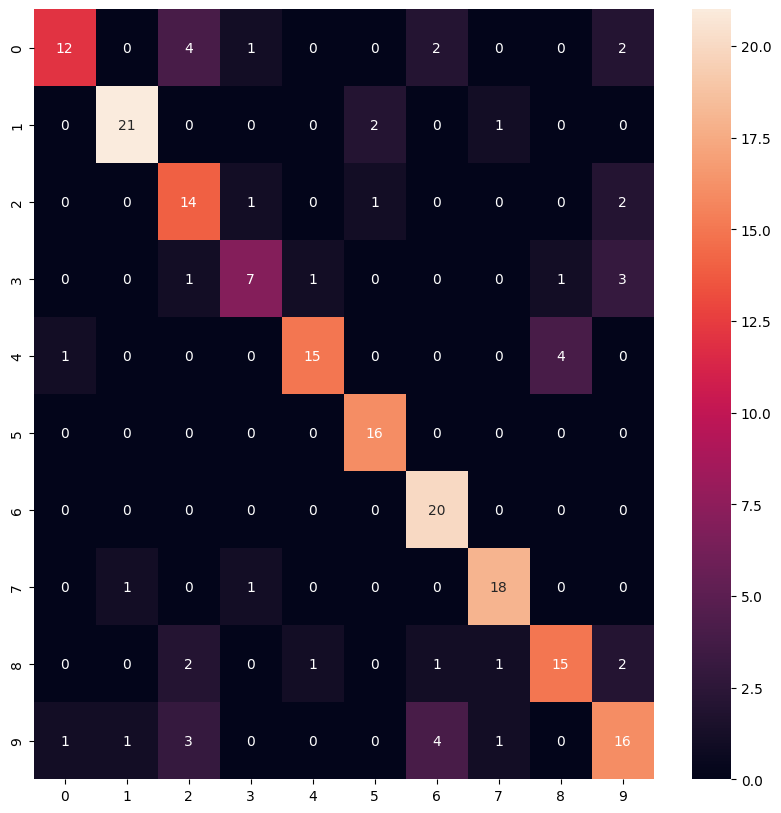

In [15]:
plt.figure(figsize = (10,10))
sn.heatmap(result['eval_confusion_matrix'], annot=True)
